# Final Report

In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

# !!! IMPORTANT !!! CHECK whether `t`  is `np.arange(0,20,1/19)`, this affects FFT results 

In [2]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])

In [3]:
EGFP.t[1] == 1/19 #check correctness of time array

True

### Continuous phasor

In [ ]:
#  EGFP.generate_df(func=EGFP.phasor_eq_func_cont)

### Discrete, just trimming

In [ ]:
EGFP.generate_df()

### Discrete, FFT deconvolution

In [ ]:
# EGFP.generate_df(deconv =True)

### Discrete, close-form

In [ ]:
EGFP.generate_df(func = EGFP.phasor_eq_func_DFT)

## PHASOR DF GENERATION
### can skip the commented cell if the csvs are saved

In [ ]:
# N_i = 20  #n_photon number
# N_j = 100 #repeat sim number
# n_photon_arr = np.logspace(4,9,N_i).astype(int)
# df_p_list = []
# for i in range(N_i):
#     EGFP.n_photon = n_photon_arr[i]
#     EGFP.repeat_sim(N_j)
#     df    = EGFP.generate_df(phasor_data = EGFP.phasor_data)[['A1','tau1','tau2','success','nfev']]
#     df_bg = EGFP.generate_df(phasor_data = EGFP.phasor_data_bg)[['A1','tau1','tau2','success','nfev']]
#     df_cont = EGFP.generate_df(func = EGFP.phasor_eq_func_cont)[['A1','tau1','tau2','success','nfev']]
#     df_dis = EGFP.generate_df(func = EGFP.phasor_eq_func_DFT)[['A1','tau1','tau2','success','nfev']]
#     df_deconv = EGFP.generate_df(deconv = True)[['A1','tau1','tau2','success','nfev']]
#     df_p_list.append([df,df_bg,df_cont,df_dis,df_deconv])
# df_p = n_case_df(df_p_list,['no_bg','bg','cont','dis','deconv']) #phasor df for different cases
# # df_p.to_csv('df/df_phasor.csv')

In [120]:
idx = pd.IndexSlice
def n_case_df(df_list,col):
    '''Return df for cases in df_list
       Input:
       df_list  list of the structure [[df_1,df_2,...df_n_case],...,] (nested list of 20 (n_photon_arr) by n_case)
       col      col names for the cases'''
    df_list_case = []
    for df in df_list:
        n_val_df =pd.concat(df,keys = col,axis = 1) #concat dfs of n cases along axis 1
        df_list_case.append(n_val_df) #append each photon number case
    return pd.concat(df_list_case,keys = range(20)) 

def df_fail(df):
    col1,col2 = df.columns.levels #multi level columns
    for col in col1:
        idx_tau_close = np.isclose(df[col].tau1,df[col].tau2,atol = 0.1) #index where taus are close (cannot resolve)
        idx_A1_large  = df[col].A1>0.9
        idx_A1_small = df[col].A1<0.1
        if 'A2' in col2:
            idx_A2_large  = df[col].A2>0.9
            df.loc[idx_A2_large ,idx[col,'success']] = False
        df.loc[idx_tau_close,idx[col,'success']] = False
        df.loc[idx_A1_large ,idx[col,'success']] = False
        df.loc[idx_A1_small ,idx[col,'success']] = False
    return df

In [6]:
N_i = 20  #n_photon number
N_j = 100 #repeat sim number
n_photon_arr = np.logspace(4,9,N_i).astype(int)
# df_lm_list = []
# for i,n_photon in enumerate(n_photon_arr):
#     EGFP.n_photon = n_photon
#     EGFP.repeat_sim(N_j)
#     df_lm_list.append(EGFP.val_df(2,sim_data = EGFP.sim_data, method = 'leastsq')) #store dataframe of 100 sims
# df_lm = pd.concat(df_lm_list,keys = range(20))
# df_lm.columns = pd.MultiIndex.from_product([['no_bg'],list(df_lm.columns)]) #follow col structure of other dfs
# df_lm.to_csv('df/df_lm.csv')#save as lm in the sense of Levenberg Marquardt algorithm

In [265]:
df_mle = pd.read_csv('df/df_mle.csv',header=[0, 1], index_col=[0,1] ) #df_p --df for mle
df_ls  = pd.read_csv('df/df_ls.csv',header=[0, 1], index_col=[0,1] ) #df_ls --df for leastsq
df_p   = pd.read_csv('df/df_phasor.csv',header=[0, 1], index_col=[0,1] ) #df_p --df for phasor
df_lm   = pd.read_csv('df/df_lm.csv',header=[0, 1],index_col=[0,1] ) #df_lm  levenberg marquardts algorithm
df_geo = pd.read_csv('df/geo_valid_df.csv',header=[0, 1], index_col=[0,1] ) #df gemoetric solution
df_p_123 = pd.read_csv('df/df_p_123.csv',header=[0, 1], index_col=[0,1] ) #df phasor n = 1,2,3
df_dict = {'mle': df_mle, 'ls':df_ls,'lm':df_lm, 'p':df_p,'geo':df_geo, 'p_123': df_p_123}

In [266]:
for k,v in df_dict.items():
    v= df_fail(v)

In [267]:
#separate out rescaled data df
df_mle_rescale = df_mle[['bg_rescale','no_bg_rescale']]
col2 = ['c','A1','A2','tau1','tau2','red_chi2','nfev','success']
df_mle_rescale.columns = pd.MultiIndex.from_product([['bg','no_bg'],col2])
df_ls_rescale = df_ls[['bg_rescale','no_bg_rescale']]
df_ls_rescale.columns = pd.MultiIndex.from_product([['bg','no_bg'],col2])
df_dict.update({'mle_rescale' : df_mle_rescale,
'ls_rescale' : df_ls_rescale})

In [268]:
#dictionary to store df of failures only
fail_dict ={k:v[v.bg.success == False] for k,v in zip(['mle_bg','ls_bg'],[df_mle,df_ls])}
fail_dict.update({'p':df_p[df_p.no_bg.success == False],
                  'mle':df_mle[df_mle.no_bg.success == False],
                  'ls':df_mle[df_ls.no_bg.success == False], 
                  'p_123' : df_p_123[df_p_123.no_bg.success == False],
                  'p_bg' : df_p_123[df_p.bg.success == False],
                  'p_123_bg' : df_p_123[df_p_123.bg.success == False]})
#dictionary to store count
fail_count_dict = {}
for k,v in fail_dict.items():
    fail_count = np.zeros(20)
    fail = v.groupby(level=0).size() #count number of failures of each n_photon
    fail_count[:len(fail)] = fail
    fail_count_dict.update({k:fail_count})

In [269]:
def fail_count_plot(keys = ['p','p_123','mle','ls']):
    marker = ['-o','-x','-^','-<','-*','-d']
    
    n_photon_arr = np.logspace(4,9,20).astype(int)
    trim_idx = n_photon_arr>5e4
    fig = plt.figure(figsize = (6,4))
    plt.title('Number of Failures Out of 100 Simulations')
    for i, key in enumerate(keys):
        plt.plot(n_photon_arr[trim_idx],fail_count_dict[key][trim_idx],marker[i],label = key)

    #plt.plot(n_photon_arr2,fail_count_fit,'x',label = 'MLE (w/ bg, no rescale)')
    plt.xscale('log')
    plt.xlabel('Total number of photons')
    plt.ylabel('Fail count')
    plt.legend()
    return fig

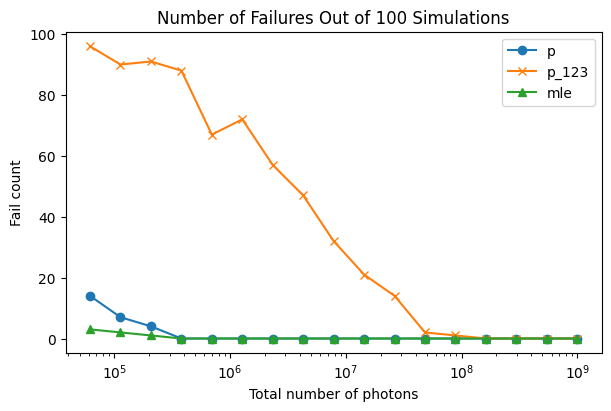

In [138]:
fig = fail_count_plot(['p','p_123','mle'])

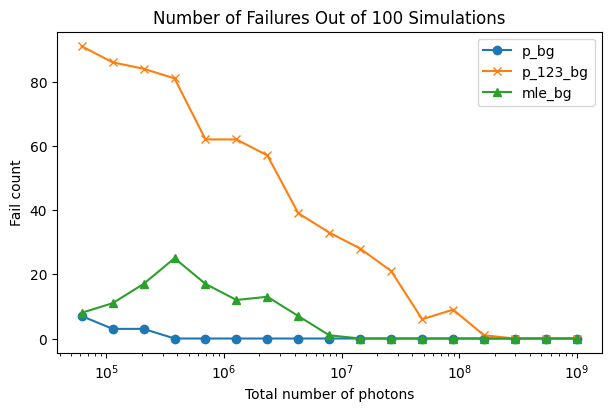

In [140]:
fig = fail_count_plot(['p_bg','p_123_bg','mle_bg'])

In [332]:
col1,col2 = df_p.columns.levels
true_dict = {'A1' : EGFP.amp[0], 'tau1' : EGFP.tau[0], 'tau2':EGFP.tau[1]} 
def dev_plot(df_names = ['mle','p','geo'], cases = ['no_bg','bg'],pars = ['A1','tau1','tau2'],
id_slice = slice(0,len(n_photon_arr)),success = False,compare_cases = True,accuracy=False):
        '''Plot mean and std as error bar for diffeent photon count
           df_names    choose list of name of df to be plotted
           cases       e.g. list of cases  no_bg, bg
           pars        list of parameter names
           id_slice    slice for plots array
           success     choose successful instances only
           compare_cases  different cases will be plotted in separate columns, df in same ax, False the opposite'''
        if compare_cases == True:
                ncol = len(cases)
        else: 
                ncol  = len(df_names)
        fig,ax = plt.subplots(len(pars),ncol,figsize = (4.25*ncol,3*len(pars)),sharey = 'row',sharex = True)
        ax = np.array(ax).flatten()
        for j,par in enumerate(pars):
                for i_df, name in enumerate(df_names):
                        for i_case,case in enumerate(cases):
                                df = df_dict[name]
                                if success == True:
                                        df = df[df[case].success == True] #select successful only
                                mean = df.loc(axis=1)[case,par].groupby(level=0).mean()
                                std  = df.loc(axis=1)[case,par].groupby(level=0).std()
                                acc = (1-abs(mean[id_slice]-true_dict[par])/true_dict[par])*100 #accuracy
                                if compare_cases == True:
                                        i = i_case
                                        i2 = i_df
                                else:
                                        i = i_df
                                        i2 = i_case
                                if accuracy == False:
                                        ax[ncol*j+i].errorbar(n_photon_arr[id_slice],mean[id_slice],yerr=std[id_slice]
                                              ,fmt='x',label = f'{name} {case}',capsize=2)
                                        ax[ncol*j+i].set_ylabel(par)
                                if accuracy == True:
                                        ax[ncol*j+i].plot(n_photon_arr[id_slice],
                                                         (1-abs(mean[id_slice]-true_dict[par])/true_dict[par])*100,['^','*'][i2]
                                                        , label = f'{name} {case}')
                                        ax[ncol*j+i].set_ylabel(f'{par} accuracy / %')
                                        try:
                                                
                                                min_photon = n_photon_arr[acc>99.5][0]
                                                ax[ncol*j+i].axvline(min_photon,c=['r','k'][i2],ls =['--',':'][i2], label = f'{name} {case}, N = {min_photon:0.2g}')
                                        except:
                                                pass
                                        
                                ax[ncol*j+i].set_xscale('log')
                                
                                if j == len(pars)-1 :
                                        ax[ncol*j+i].set_xlabel('Total Photon Count')
        for i in range(len(pars)):
                for j in range(ncol):
                        if accuracy == False:
                                ax[ncol*i+j].axhline(true_dict[pars[i]],c='k',label = 'True')      
                        ax[ncol*i+j].legend()
                                
        return fig,ax
#fig.savefig('fig/phasor_params_cases.pdf')
        

In [323]:
mean = df_mle.bg.tau1.groupby(level=0).mean()
acc = (1-abs(mean-true_dict['tau1'])/true_dict['tau1'])*100
np.argsort(acc[acc>99.5])

13    0
14    2
15    1
16    4
17    5
18    6
19    3
Name: tau1, dtype: int64

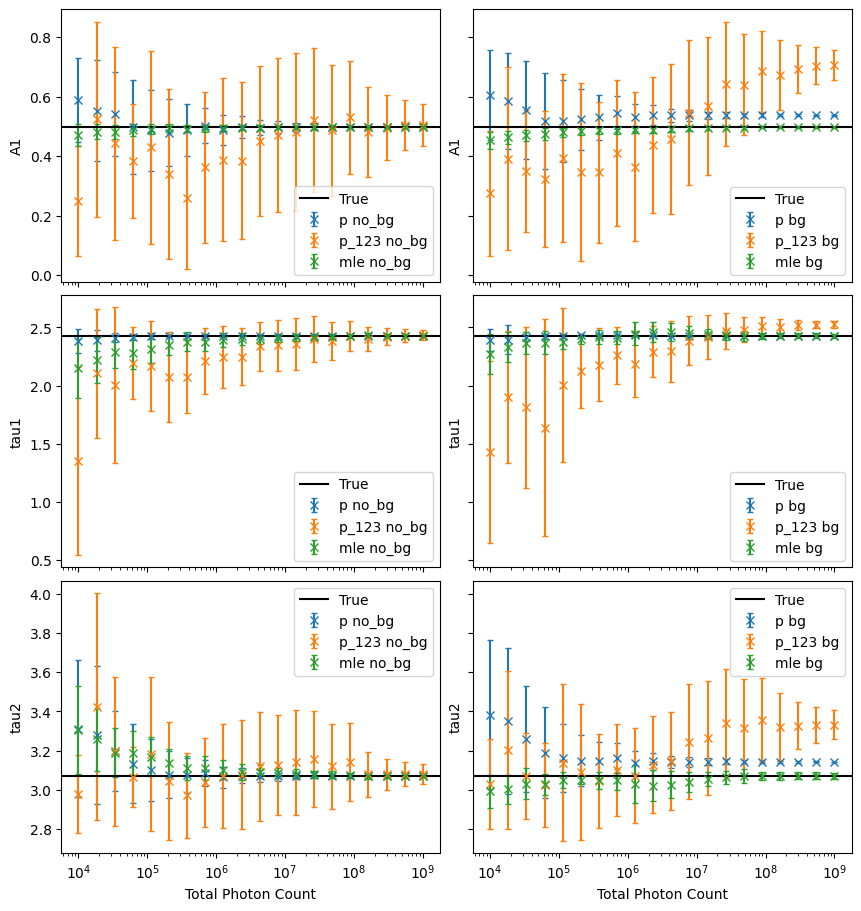

In [306]:
fig,ax  = dev_plot(df_names = ['p','p_123','mle'], cases = ['no_bg','bg'],pars = ['A1','tau1','tau2'],success = True)
#fig.savefig('fig/mle_p_compare.pdf')

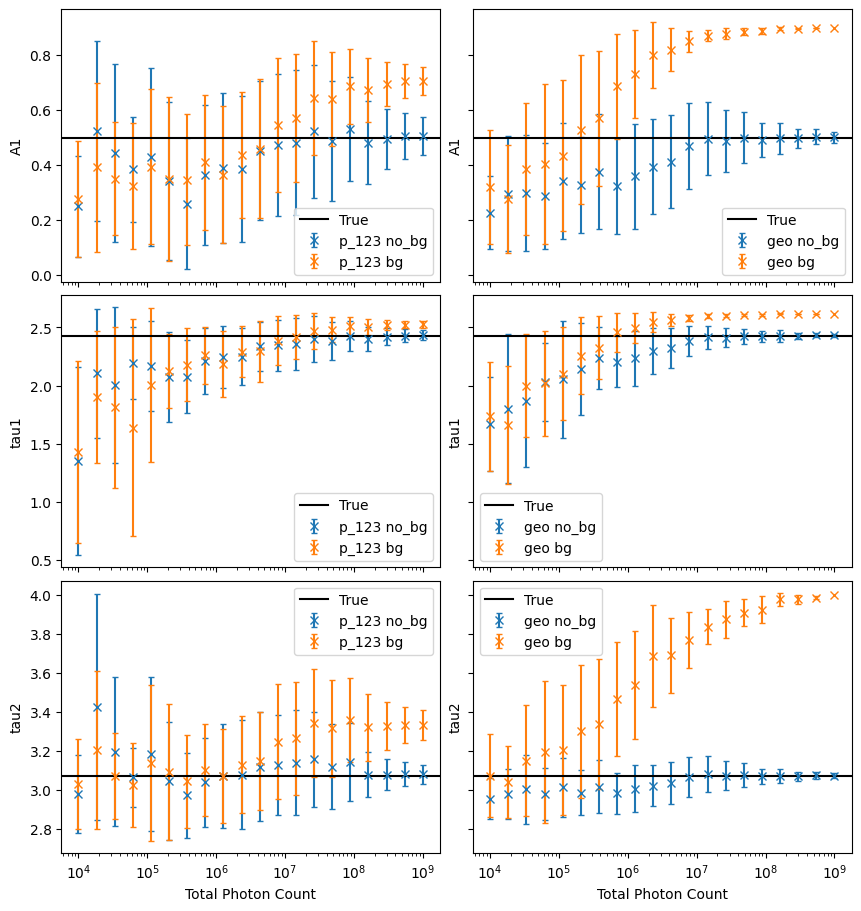

In [205]:
fig,ax  = dev_plot(df_names = ['p_123','geo'], cases = ['no_bg','bg'],pars = ['A1','tau1','tau2'],compare_cases =False,success =True)
fig.savefig('fig/p_123_geo_dev.pdf')

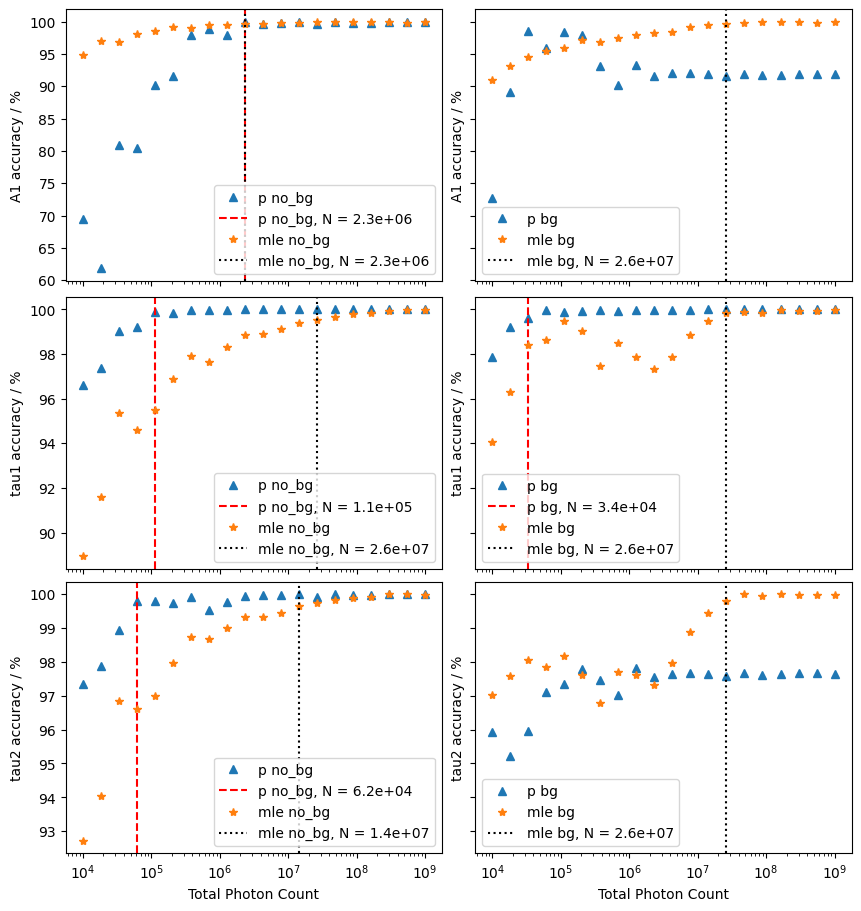

In [333]:
fig,ax  = dev_plot(df_names = ['p','mle'], cases = ['no_bg','bg'],pars = ['A1','tau1','tau2'],accuracy =True)

In [334]:
fig.savefig('fig/mle_p_accuracy.pdf')

In [273]:
#drop anamolously high values
df_mle_rescale = df_mle_rescale.drop(df_mle_rescale[df_mle_rescale.no_bg.tau2>10].index)
df_ls_rescale = df_ls_rescale.drop(df_ls_rescale[df_ls_rescale.no_bg.tau2>10].index)
df_dict.update({'mle_rescale' : df_mle_rescale, 'ls_rescale': df_ls_rescale })

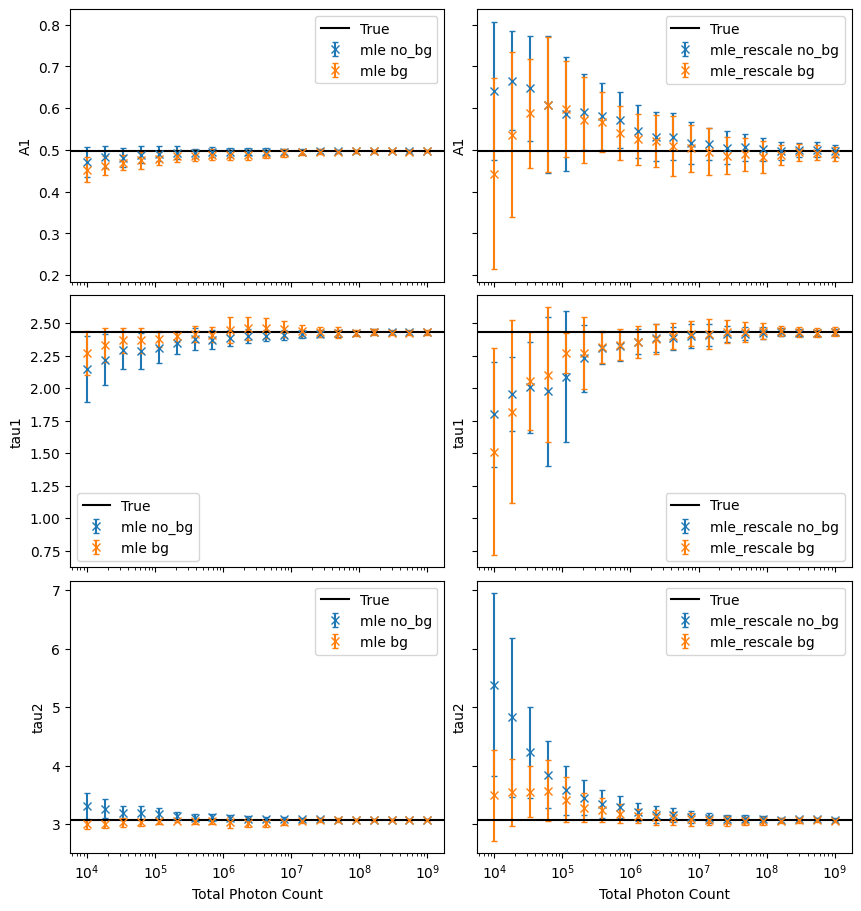

In [274]:
fig,ax  = dev_plot(df_names = ['mle','mle_rescale'], cases = ['no_bg','bg'],pars = ['A1','tau1','tau2'],success = True,compare_cases = False)

In [275]:
fig.savefig('fig/mle_rescale.pdf')

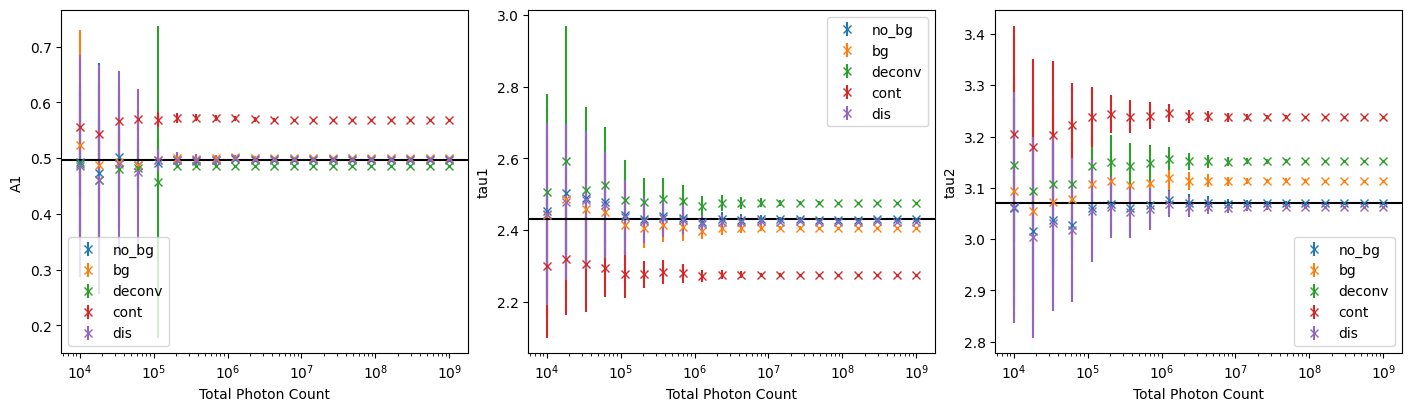

In [ ]:
col1,col2 = df_p.columns.levels
fig,ax = plt.subplots(1,3,figsize = (14,4))
for i,par in enumerate(['A1','tau1','tau2']):
    for j,case in enumerate(['no_bg','bg','deconv','cont','dis']):
            mean = df_p.loc(axis=1)[case,par].groupby(level=0).mean()
            std  = df_p.loc(axis=1)[case,par].groupby(level=0).std()
            ax[i].errorbar(n_photon_arr,mean,yerr=std,fmt='x',label = case)
            ax[i].set_xscale('log')
            ax[i].set_xlabel('Total Photon Count')
            ax[i].set_ylabel(par)
            ax[i].legend()
    ax[i].axhline([EGFP.amp[0],*EGFP.tau][i],c='k',label = 'True')
fig.savefig('fig/phasor_params_cases.pdf')
        

In [ ]:
fig.s

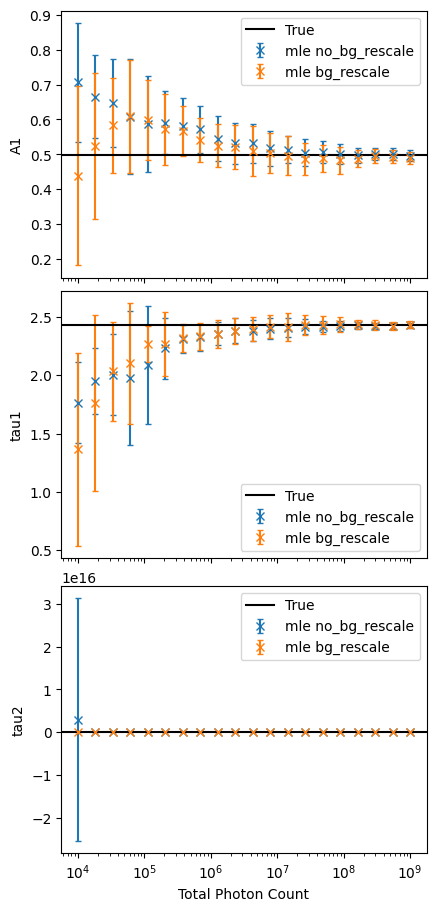

In [213]:
fig,ax  = dev_plot(df_names = ['mle'], cases = ['no_bg_rescale','bg_rescale'],pars = ['A1','tau1','tau2'],success = True,compare_cases = False)

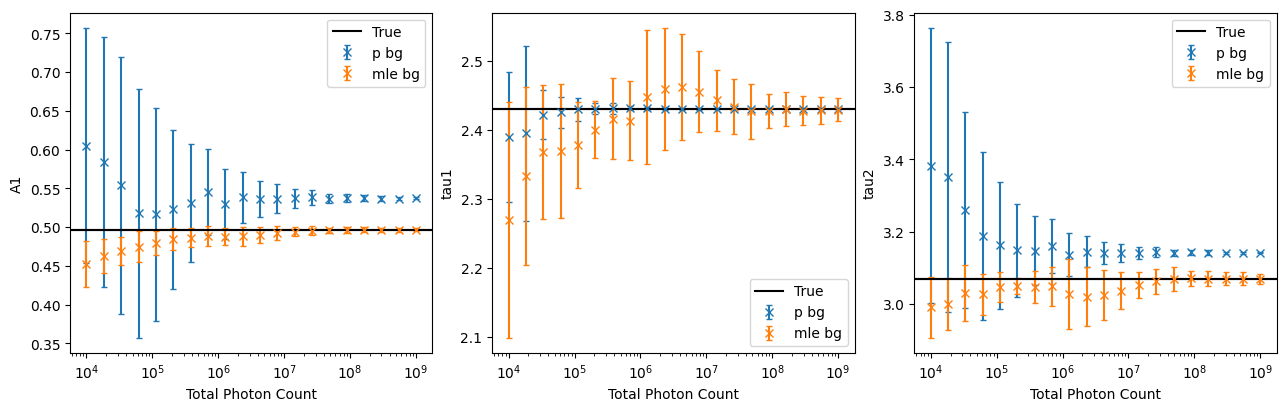

In [161]:
fig,ax = dev_plot(df_names = ['p','mle'], cases = ['bg'],pars = ['A1','tau1','tau2'],id_slice = slice(0,len(n_photon_arr)),success = True)
fig.savefig('fig/mle_p_bg_dev.pdf')

In [47]:

def hist_plot(sim, n=15,n_photon =None,method = 'powell',df_names = ['mle','lm','p','geo'],cases =['no_bg'],pars = ['A1','tau1','tau2']):
    '''Plot histograms of parameters obtained from repeated simulations
       Inputs:
       sim         Phasor object
       n_photon    total number of photons for simulation
       method      fit method
       df_names    list of keys for df_dict
       cases       list of cases
       pars        list of parameters to be plotted '''
    #set n_photon if it is provided
    n_photon = n_photon_arr[n]
    fig, axes = plt.subplots(nrows=1, ncols=len(pars), figsize=(5*len(pars), 5),constrained_layout = True)
    axes = np.array(axes).flatten()
    fig.suptitle(f'Total number of photons = {n_photon}')
    colors = cm.rainbow(np.linspace(0, 1, len(df_names)))
    for k,case in enumerate(cases):
        for i,par in enumerate(pars):
            # Plot the histogram on the corresponding axis
            if par in true_dict:
                axes[i].axvline(true_dict[par].real,lw = 2,c = 'r',label = 'true')
            for j,name in enumerate(df_names):
                df = df_dict[name]
                val = np.real(df.loc[idx[n,:],idx[case,par]])
                axes[i].hist(np.abs(val),label = f'{name} {case}' ,alpha = 0.5)
                axes[i].axvline(abs(np.mean(val)),lw = 2,ls = '--',c=colors[j],label = f'{name} {case} mean')
            axes[i].legend()
            axes[i].set_xlabel(par)
            axes[i].set_ylabel('Frequency')
        return fig, axes

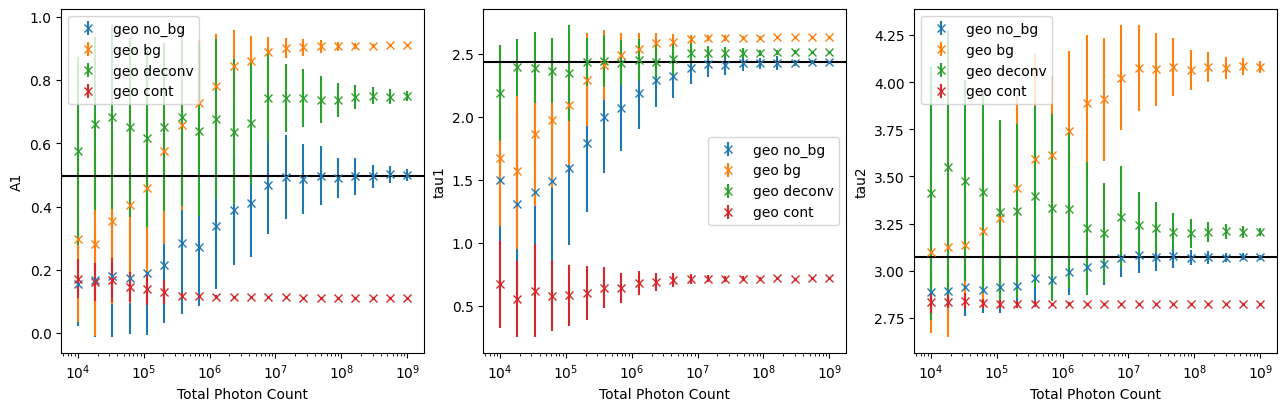

In [51]:
fig,ax = dev_plot(df_names = ['geo'], cases = ['no_bg','bg','deconv','cont'],id_slice = slice(20)) #geometric and numerical comparison

In [49]:
fig.savefig('fig/geo_dev_cases.pdf')

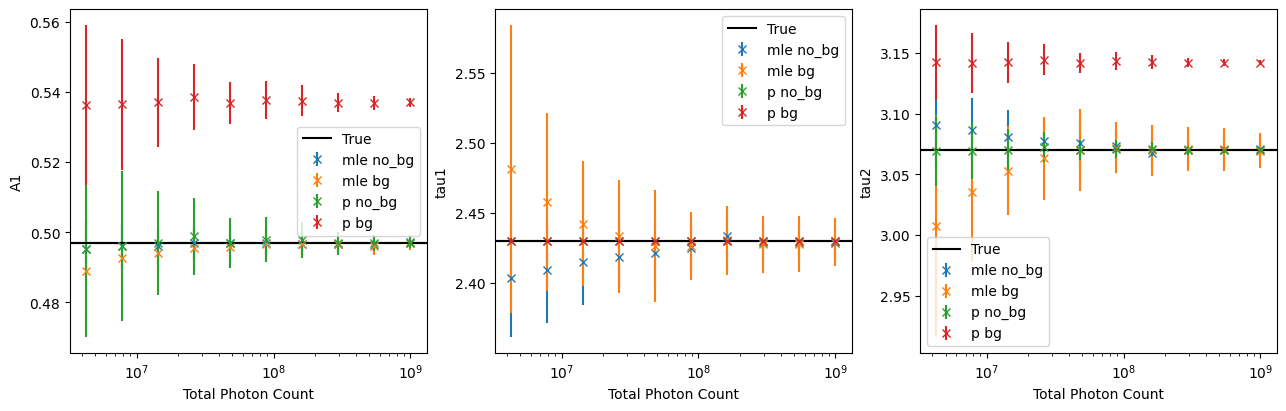

In [11]:
fig,ax = dev_plot(df_names = ['mle','p'], cases = ['no_bg','bg'],id_slice = slice(10,20))

POWELL & LEVENBERG MARQUARDTZ

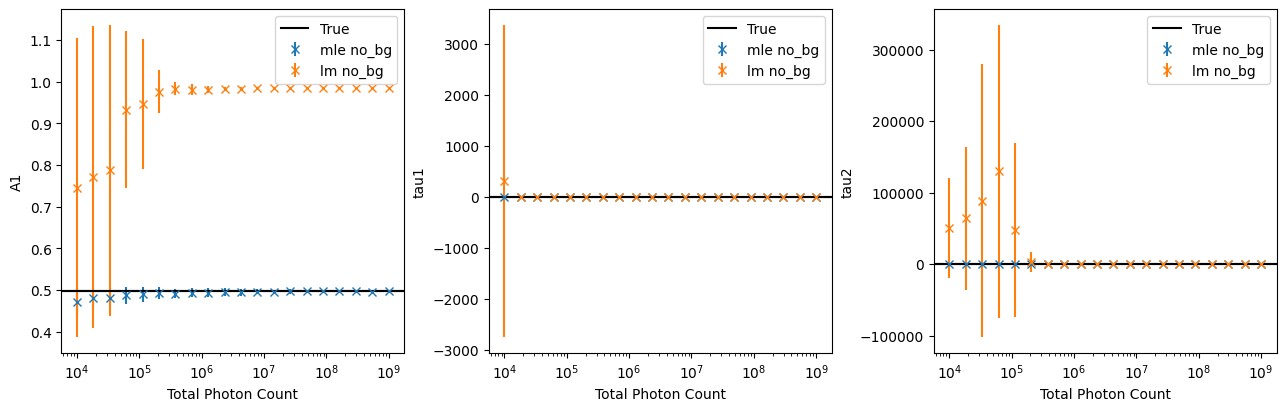

In [13]:
fig,ax = dev_plot(df_names = ['mle','lm'], cases = ['no_bg'],id_slice = slice(0,20)) #geometric and numerical comparison

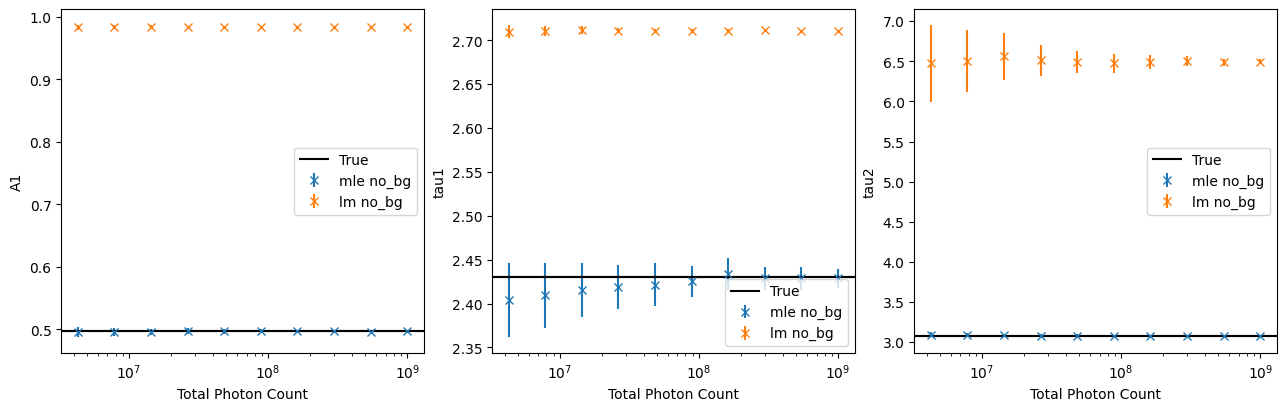

In [14]:
fig,ax = dev_plot(df_names = ['mle','lm'], cases = ['no_bg'],id_slice = slice(10,20)) #geometric and numerical comparison

MLE PHASOR BG NO BG

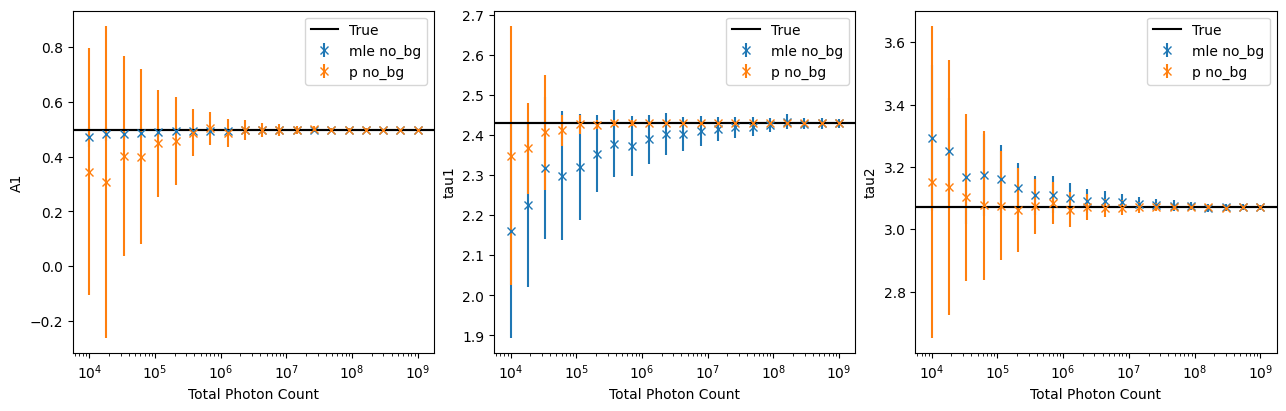

In [55]:
fig,ax = dev_plot(df_names = ['mle','p'], cases = ['no_bg'],id_slice = slice(0,20)) #geometric and numerical comparison

(<Figure size 1500x500 with 3 Axes>,
 array([<AxesSubplot:xlabel='A1', ylabel='Frequency'>,
        <AxesSubplot:xlabel='tau1', ylabel='Frequency'>,
        <AxesSubplot:xlabel='tau2', ylabel='Frequency'>], dtype=object))

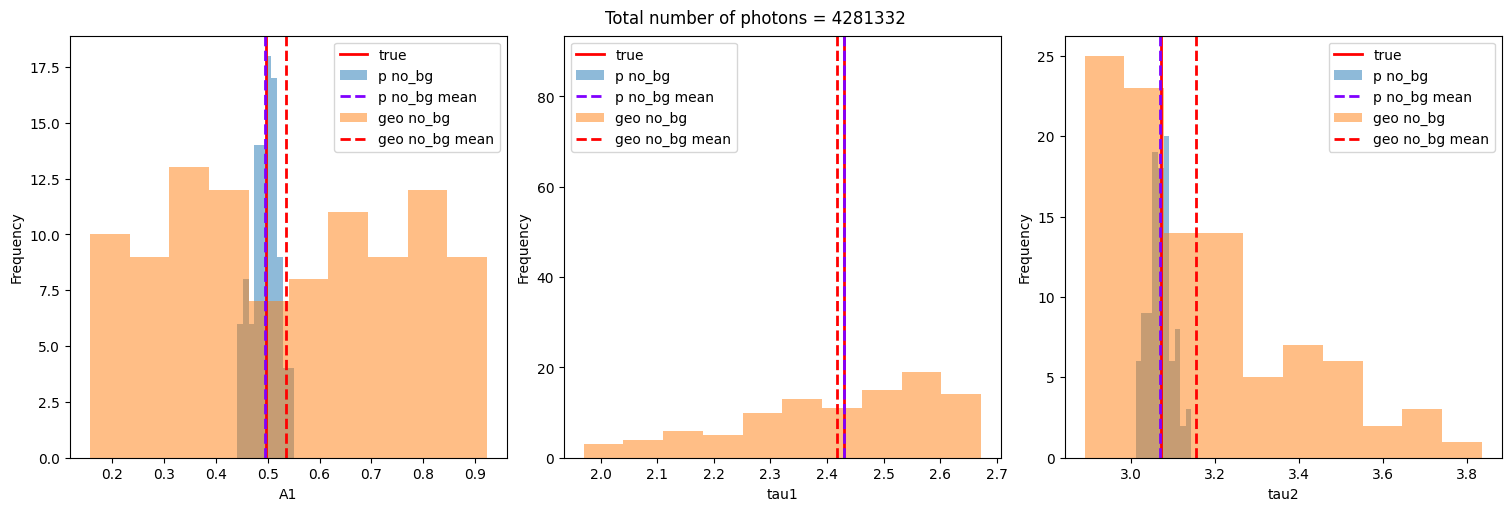

In [23]:
hist_plot(EGFP,n=10,df_names= ['p','geo'],cases = ['no_bg'] )

Reduced $\chi^2$

(<Figure size 500x500 with 1 Axes>, array([<AxesSubplot:>], dtype=object))

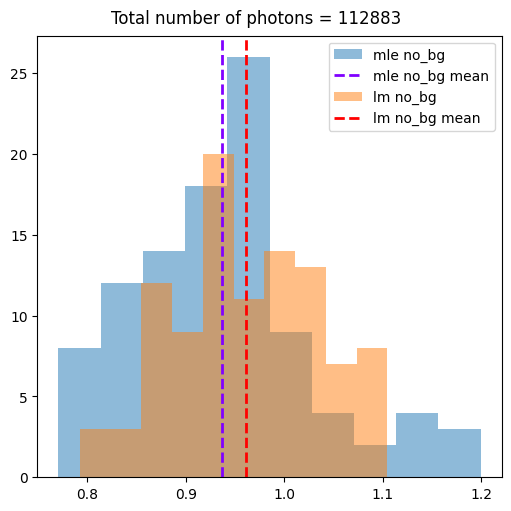

In [21]:
hist_plot(EGFP,n=4,df_names= ['mle','lm'],cases = ['no_bg'],pars = ['red_chi2'] )

In [ ]:
df2 = EGFP.generate_df(idx = [1,2,3])[['A1','tau1','tau2']].head(3)
df1 = EGFP.generate_df(idx = [0,1,2])[['A1','tau1','tau2']].head(3)
df_wrong = pd.concat([df1,df2],keys = ['012','123'])

In [67]:
df_wrong = pd.concat([df1,df2],keys = ['012','123'])

In [ ]:
print(df_wrong.to_latex(float_format=lambda x: f'{x:.3f}'))

In [105]:
def hist_plot_n(sim, n_arr=[1,10,19],n_photon =None,method = 'powell',df_names = ['mle','lm','p','geo'],cases =['no_bg'],par ='tau2'):
    '''Plot histograms of parameters obtained from repeated simulations
       Inputs:
       sim         Phasor object
       n_photon    total number of photons for simulation
       method      fit method
       df_names    list of keys for df_dict
       cases       list of cases
       pars        list of parameters to be plotted '''
    #set n_photon if it is provided
    fig, axes = plt.subplots(nrows=1, ncols=len(n_arr), figsize=(5*len(n_arr), 5),constrained_layout = True)
    axes = np.array(axes).flatten()
    colors = cm.rainbow(np.linspace(0, 1, len(cases)))
    for k,case in enumerate(cases):
        for i,n in enumerate(n_arr):
            n_photon = n_photon_arr[n]
            # Plot the histogram on the corresponding axis
            if par in true_dict:
                axes[i].axvline(true_dict[par].real,lw = 2,c = 'r',label = 'true')
            for j,name in enumerate(df_names):
                df = df_dict[name]
                val = np.real(df.loc[idx[n,:],idx[case,par]])
                axes[i].hist(np.abs(val),label = f'{name} {case}' ,alpha = 0.5)
                axes[i].axvline(abs(np.mean(val)),lw = 2,ls = '--',c=colors[k],label = f'{name} {case} mean')
            axes[i].legend()
            axes[i].set_xlabel('Lifetime')
            axes[i].set_ylabel('Frequency')
            axes[i].set_title(f'Total photon count = {n_photon}')
    return fig, axes

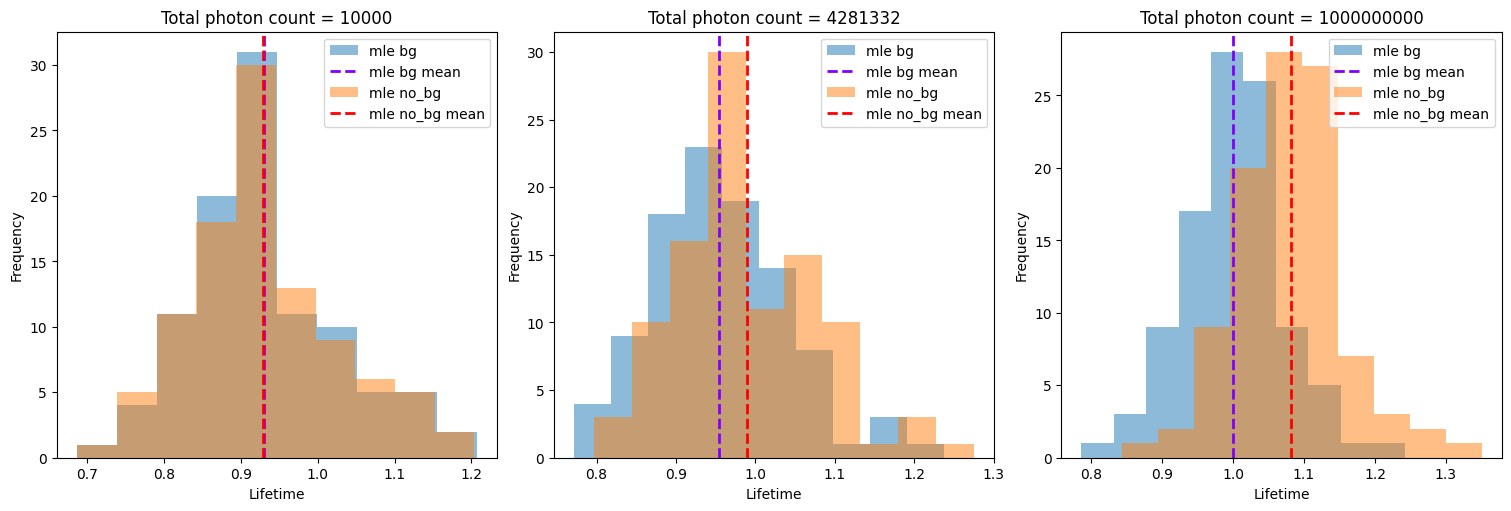

In [106]:
fig,ax = hist_plot_n(EGFP,n_arr = [0,10,19],df_names=['mle'],cases = ['bg','no_bg'],par = 'red_chi2')

In [108]:
for i in range(3):
    ax[i].set_xlabel(r'Reduced $\chi^2$')

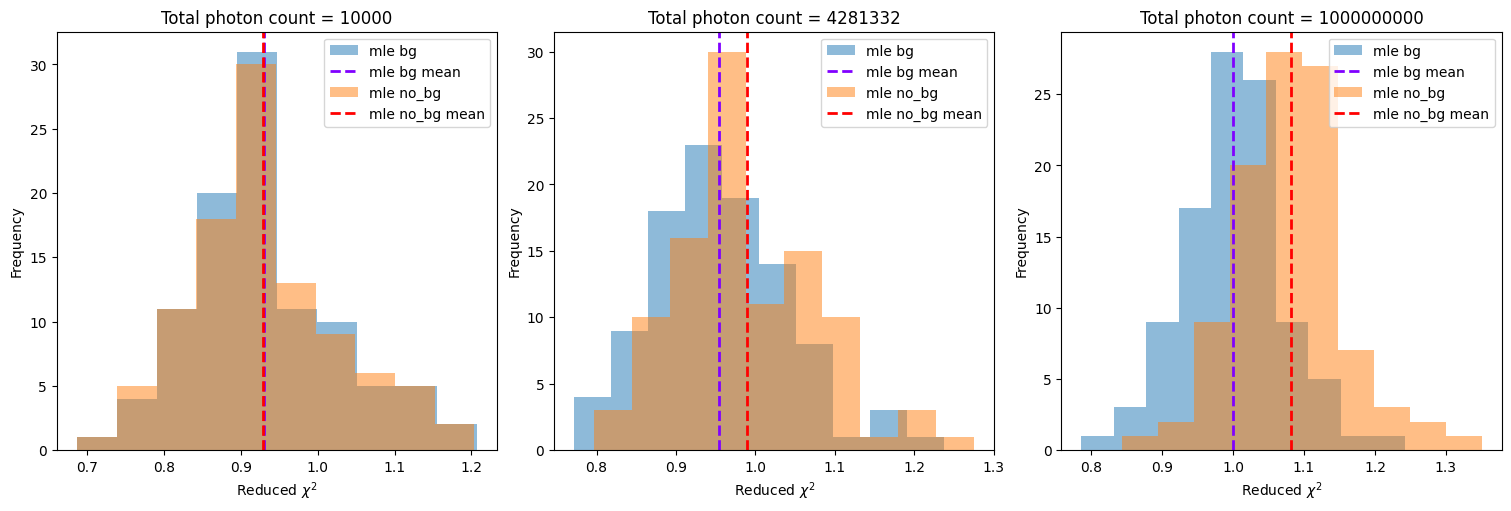

In [109]:
fig

In [110]:
fig.savefig('fig/mle_chi2.pdf')

In [283]:
std = df_p.groupby(level=0).std()
std.no_bg.tau2/2.43*np.sqrt(n_photon_arr)

0     20.541034
1     22.795615
2     20.245214
3     24.298032
4     24.143954
5     25.257172
6     22.654376
7     23.081494
8     25.542440
9     25.533225
10    24.593973
11    27.222772
12    26.242983
13    26.373628
14    22.917204
15    28.247899
16    30.274158
17    25.832422
18    25.701947
19    21.757652
Name: tau2, dtype: float64